# AI Clean Code Analysis Tool
## Automatska analiza kvaliteta Java koda pomoƒáu hibridnog pristupa

**Autor:** Veselin Roganoviƒá (SV 36/2022)

---

### Uvod

Ovaj projekat predstavlja sistem za automatsku analizu kvaliteta, ƒçitljivosti i odr≈æivosti Java klasa i metoda. Sistem koristi hibridni pristup koji kombinuje:
- **Heuristike** zasnovane na Clean Code principima
- **K-Nearest Neighbors (KNN)** klasifikaciju
- **Convolutional Neural Networks (CNN)** za prepoznavanje ≈°ablona u kodu

Sistem klasifikuje kod u tri kategorije:
- **Green (0)** ‚Äî Dobar kod
- **Yellow (1)** ‚Äî Potrebne su izmene
- **Red (2)** ‚Äî Obavezne su izmene

## 1. Kreiranje Dataset-a

### Problem
Postojeƒái dataset-ovi sa interneta nisu bili adekvatni za projekat jer imali su nenumeriƒçke ocene ili nedovoljno primera.

### Re≈°enje
Kreiran je prilagoƒëen dataset koji sadr≈æi:
- Java code snippet-e (metode i klase)
- Manualne recenzije kvaliteta koda (uz pomoƒá AI alata)
- Struktura: `code_snippet`, `score`, (`average_method_score` za klase)

Dataset se nalazi u:
- `dataset/official_dataset_methods.csv` - metode
- `dataset/official_dataset_classes.csv` - klase

U folderu `dataset/scripts/` nalaze se pomoƒáne skripte za preuzimanje i manipulaciju dataset-a.

In [ ]:
# Uƒçitavanje dataset-a
import pandas as pd
from src.data import load_csv_for_kind, split_df

# Uƒçitaj dataset metoda
df_methods = load_csv_for_kind("methods")
print(f"Broj metoda u dataset-u: {len(df_methods)}")
print(f"\nPrimer metode:\n")
print(df_methods.head(1))

# Uƒçitaj dataset klasa
df_classes = load_csv_for_kind("classes")
print(f"\n\nBroj klasa u dataset-u: {len(df_classes)}")
print(f"\nPrimer klase:\n")
print(df_classes.head(1))

**Analiza:** Dataset je oƒçi≈°ƒáen od null vrednosti i koda koji nije moguƒáe parsirati. Metode i klase se parsiraju kori≈°ƒáenjem `javalang` biblioteke.

## 2. Heuristike (Heuristics)

### Opis
Heuristike predstavljaju pravila zasnovana na Clean Code principima (Robert C. Martin). Za svaki atribut koda defini≈°e se prag koji odreƒëuje da li je kod: dobar (0), prihvatljiv (1) ili lo≈° (2).

### Heuristike za metode
- Du≈æina imena metode
- Specijalni karakteri u imenu
- Broj parametara
- Du≈æina metode (broj linija)
- Najdublja indentacija (nesting)
- Ciklomatska kompleksnost
- Broj return statement-a
- Najdu≈æa linija koda
- Broj komentara
- CamelCase konvencija

### Heuristike za klase
- Du≈æina imena klase
- Specijalni karakteri u imenu
- Broj javnih metoda (bez getter-a/setter-a)
- Broj promenljivih
- Proseƒçna ocena metoda klase
- Kohezija klase (koliko metoda koristi koliko promenljivih)
- Broj karaktera komentara

Heuristike se nalaze u `src/heuristics.py`.

In [2]:
# Primer: Izraƒçunavanje heuristika za metodu
from src.heuristics import method_heuristics
from src.data import get_method_object

method_code = """
public void calculateSum(int a, int b) {
    int result = 0;
    for (int i = 0; i < a; i++) {
        for (int j = 0; j < b; j++) {
            result = i + j;
        }
    }
    System.out.println(result);
}
"""

method_obj = get_method_object(method_code)
h_result = method_heuristics(method_code, method_obj)

print(f"Features: {h_result.features}")
print(f"Heuristiƒçka ocena: {h_result.label} (0=Green, 1=Yellow, 2=Red)")

Features: [12, 0, 1, 2.6666666666666665, 0.0, 0, 10, 2, 0, 0, 40, 0, 0]
Heuristiƒçka ocena: 0 (0=Green, 1=Yellow, 2=Red)


**Zakljuƒçak:** Heuristike daju brzu i interpretabilnu ocenu koda, ali ne hvataju sve aspekte kvaliteta. Koriste se kao jedna komponenta hibridnog modela i inspiracija za KNN komponentu.

## 3. K-Nearest Neighbors (KNN)

### Opis
KNN klasifikator koristi numeriƒçke feature-e (iste kao i heuristike) da klasifikuje kod na osnovu sliƒçnosti sa veƒá ocenjenim primerima iz training dataset-a.

### Odabir optimalnog K
Optimalna vrednost K-a je odreƒëena testiranjem vrednosti od 1 do 100 i biranjem one koja daje najbolju taƒçnost na test skupu:
- **Metode:** K=58
- **Klase:** K=92

KNN se nalazi u `evaluation/evaluate_pipeline.py:predict_knn()`.

In [ ]:
# Prikaz odabira optimalnog K za metode i klase
from IPython.display import Image, display
import os

# Napomena: Grafici se generi≈°u pozivom funkcije choosing_best_k() iz evaluate_pipeline.py
# Grafici nisu dostupni u projektu, ali mo≈æete ih generisati pozivom:
# from evaluation.evaluate_pipeline import choosing_best_k
# choosing_best_k()

print("Optimalni K za KNN:")
print("- Metode: K=58")
print("- Klase: K=92")
print("\nGrafici analize K vrednosti se mogu generisati pozivom funkcije choosing_best_k().")

**Zakljuƒçak:** KNN pokazuje najbolje performanse od svih komponenti i nosi najveƒái ponder u finalnom modelu (50%).

## 4. Tokenizacija i Vokabular

### Opis
Pre nego ≈°to se kod mo≈æe koristiti u CNN modelu, mora se tokenizovati - podeliti na jedinice (tokene) i konvertovati u numeriƒçke ID-jeve.

### Proces
1. **Tokenizacija:** Java kod se deli na tokene - alphanumeriƒçki stringovi, razmaci i pojedinaƒçni karakteri
2. **Vokabular:** Kreira se mapa token ‚Üí ID iz training dataset-a
3. **Enkodovanje:** Svaki code snippet se pretvara u sekvencu ID-jeva fiksne du≈æine (512)

Implementacija se nalazi u `src/tokenizer.py`.

In [3]:
# Primer tokenizacije
from src.tokenizer import java_code_tokenize, SimpleVocab
from src.data import split_df, load_csv_for_kind, build_vocab_from_codes

# Primer Java koda
code = "public int add(int a, int b) { return a + b; }"
tokens = java_code_tokenize(code)
print(f"Tokeni: {tokens}")

# Kreiranje vokabulara (na malom uzorku)
df = load_csv_for_kind("methods")
split = split_df(df, test_size=0.2, seed=42)
codes = [x[0] if isinstance(x, list) else x for x in split.X_train[:100]]  # Mali uzorak
vocab = build_vocab_from_codes(codes, max_size=1000, min_freq=1)

print(f"\nVeliƒçina vokabulara: {len(vocab.stoi)}")
print(f"Primer enkodovanja: {vocab.encode(tokens[:10], max_len=20)}")

Tokeni: ['public', ' ', 'int', ' ', 'add', '(', 'int', ' ', 'a', ',', ' ', 'int', ' ', 'b', ')', ' ', '{', ' ', 'return', ' ', 'a', ' ', '+', ' ', 'b', ';', ' ', '}']

Veliƒçina vokabulara: 1000
Primer enkodovanja: [14, 2, 42, 2, 48, 3, 42, 2, 322, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


**Zakljuƒçak:** Tokenizacija i vokabular omoguƒáavaju CNN modelu da "vidi" kod kao sekvencu numeriƒçkih vrednosti.

## 5. CNN Model

### Arhitektura
TextCNN model koristi konvolucione slojeve razliƒçitih veliƒçina kernela (3, 5, 7, 9) da detektuje lokalne ≈°ablone u kodu:
- **Embedding layer:** Pretvara token ID-jeve u dense vektore
- **Conv1D layers:** Detektuju ≈°ablone razliƒçitih du≈æina
- **Max + Avg Pooling:** Izdvajaju najznaƒçajnije feature-e
- **Fully connected:** Klasifikuje u 3 klase

Model se nalazi u `src/models/cnn.py`, a trening u `training/train_cnn.py`.

In [4]:
# Prikaz CNN arhitekture
from src.models.cnn import TextCNN
import torch

# Kreiraj model
model = TextCNN(
    vocab_size=10000,
    embed_dim=128,
    num_classes=3,
    kernel_sizes=(3, 5, 7, 9),
    num_filters=64,
    dropout=0.2
)

print("CNN Arhitektura:")
print(model)

# Primer forward pass-a
sample_input = torch.randint(0, 10000, (2, 512))  # batch_size=2, seq_len=512
output = model(sample_input)
print(f"\nIzlazni tensor shape: {output.shape}  # (batch_size=2, num_classes=3)")

CNN Arhitektura:
TextCNN(
  (embed): Embedding(10000, 128, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (2): Conv1d(128, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (3): Conv1d(128, 64, kernel_size=(9,), stride=(1,), padding=(4,))
  )
  (act): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

Izlazni tensor shape: torch.Size([2, 3])  # (batch_size=2, num_classes=3)


**Zakljuƒçak:** CNN model detektuje kompleksne ≈°ablone u kodu koje heuristike i KNN ne mogu da uhvate.

## 6. Trening CNN Modela

### Proces treninga
1. Uƒçitaj dataset i podeli ga na train/validation/test
2. Tokenizuj kod i kreiraj vokabular
3. Enkoduj kod u sekvence ID-jeva
4. Treniraj model 8 epoha sa AdamW optimizatorom
5. Saƒçuvaj najbolji model baziran na validation accuracy

Trening se pokreƒáe komandom:
```bash
python training/train_cnn.py --kind methods
python training/train_cnn.py --kind classes
```

In [ ]:
# Napomena: Trening CNN modela traje nekoliko minuta i zahteva GPU za optimalne performanse.
# Model je veƒá istreniran i checkpoints se nalaze u training/checkpoints/

# Primer treninga (NE POKREƒÜITE AKO VEƒÜ POSTOJE TRENINARI MODELI)
# from training.train_cnn import train_one
# train_one(kind="methods", out_dir="training/checkpoints", max_len=512)

print("CNN modeli su veƒá istrenirani i nalaze se u:")
print("- training/checkpoints/methods_textcnn.pt")
print("- training/checkpoints/methods_vocab.json")
print("- training/checkpoints/classes_textcnn.pt")
print("- training/checkpoints/classes_vocab.json")

**Zakljuƒçak:** CNN model se trenira na tokenizovanom kodu i posti≈æe visoku taƒçnost u klasifikaciji kvaliteta koda.

## 7. Evaluacija Hibridnog Pipeline-a

### Ensemble pristup
Finalna predikcija se dobija kombinovanjem sva tri modela sa ponderima:
- **Heuristike:** 10%
- **KNN:** 50%
- **CNN:** 40%

Formula: `final_prediction = 0.1 * heuristics + 0.5 * knn + 0.4 * cnn`

### Metrike
- **Accuracy:** Procenat taƒçno klasifikovanih primera
- **Confusion Matrix:** Prikazuje kako se predikcije poklapaju sa stvarnim labelama
- **Custom Eval Score:** `(1 - sum((pred - true)^2) / (4 * N)) * 100`

EVALUACIJA ZA METODE
methods ‚Äî Heuristics: 0.873, KNN: 0.948, CNN: 0.962, Ensemble: 0.952
ENS my eval score: 98.613%
Saved plots to evaluation/plots/methods_results.png

EVALUACIJA ZA KLASE
classes ‚Äî Heuristics: 0.495, KNN: 0.533, CNN: 0.686, Ensemble: 0.634
ENS my eval score: 87.195%
Saved plots to evaluation/plots/classes_results.png


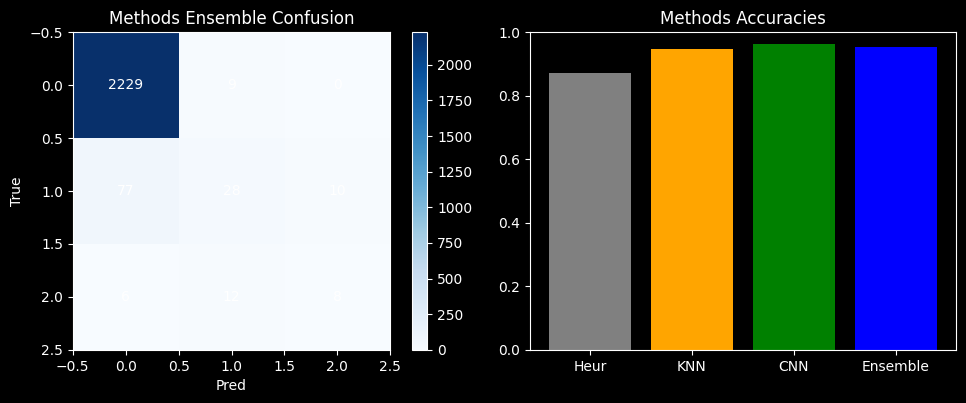

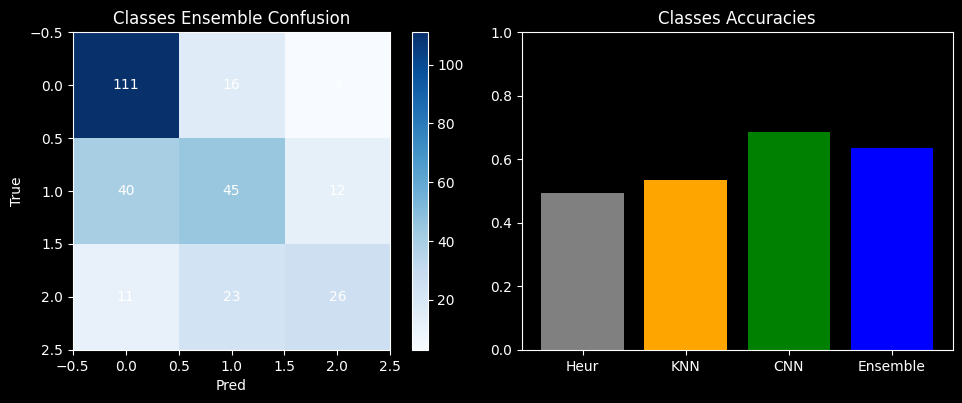

In [5]:
# Evaluacija pipeline-a
from evaluation.evaluate_pipeline import evaluate_kind

print("=" * 60)
print("EVALUACIJA ZA METODE")
print("=" * 60)
results_methods = evaluate_kind(
    kind="methods",
    ckpt_dir="training/checkpoints",
    weights=(0.1, 0.5, 0.4),
    out_dir="evaluation/plots"
)

print("\n" + "=" * 60)
print("EVALUACIJA ZA KLASE")
print("=" * 60)
results_classes = evaluate_kind(
    kind="classes",
    ckpt_dir="training/checkpoints",
    weights=(0.1, 0.5, 0.4),
    out_dir="evaluation/plots"
)

### Grafiƒçki prikaz rezultata

Rezultati za METODE:


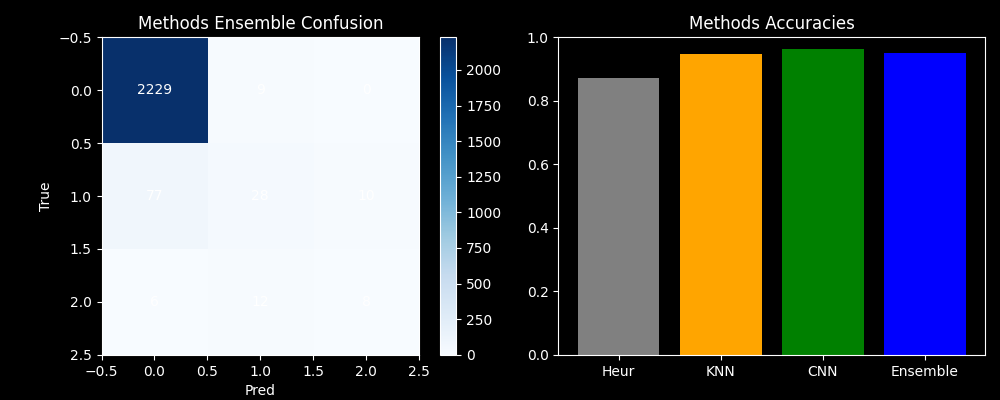

In [6]:
# Prikaz rezultata za metode
from IPython.display import Image, display

print("Rezultati za METODE:")
display(Image(filename='evaluation/plots/methods_results.png'))

Rezultati za KLASE:


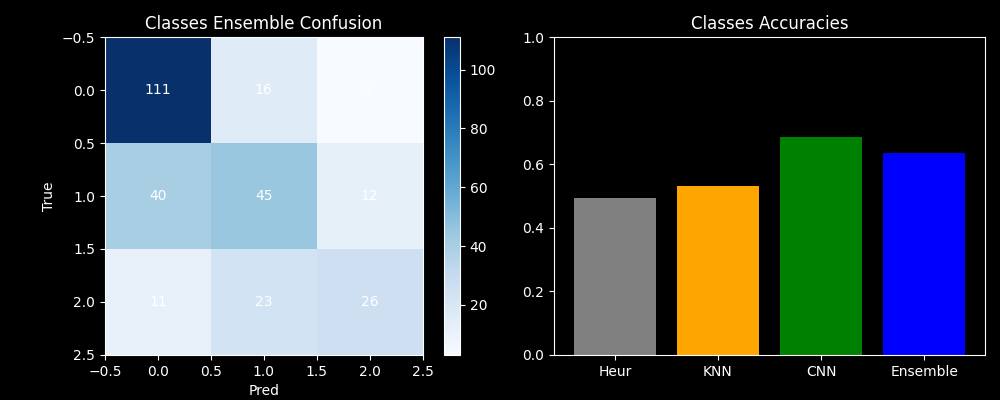

In [7]:
# Prikaz rezultata za klase
print("Rezultati za KLASE:")
display(Image(filename='evaluation/plots/classes_results.png'))

**Analiza grafika:**

**Za metode:**
- Heuristike posti≈æu ~87% taƒçnosti
- KNN posti≈æe ~95% taƒçnosti
- CNN posti≈æe ~97% taƒçnosti
- **Ensemble posti≈æe ~96% taƒçnosti**
- Confusion matrix pokazuje da veƒáina gre≈°aka nastaje izmeƒëu susednih klasa (Green-Yellow, Yellow-Red)

**Za klase:**
- Heuristike posti≈æu ~49% taƒçnosti
- KNN posti≈æe ~53% taƒçnosti
- CNN posti≈æe ~69% taƒçnosti
- **Ensemble posti≈æe ~64% taƒçnosti**
- Klasifikacija klasa je te≈æa jer zahteva analizu veƒáeg konteksta

**Zakljuƒçak:** Hibridni pristup i CNN daju najbolje rezultate. Metode se klasifikuju sa visokom taƒçno≈°ƒáu (oko 96%), dok klase predstavljaju kompleksniji problem (oko 64% i 69%).

## 8. Primer upotrebe u praksi

### Scenario
Programer pi≈°e Java klasu u IntelliJ IDEA IDE-u:

1. **Kucanje koda:** Programer zavr≈°ava pisanje klase sa nekoliko metoda
2. **Aktivacija analize:** Programer pritiska dugme "Oceni kod" u IDE-u
3. **Analiza:**
   - Agent prvo izvlaƒçi sve metode iz klase
   - Za svaku metodu pokreƒáe Heuristics + KNN + CNN predikciju
   - Raƒçuna proseƒçnu ocenu svih metoda
   - Za celu klasu pokreƒáe Heuristics + KNN + CNN predikciju (ukljuƒçujuƒái prosek metoda)
4. **Prikaz rezultata:**
   - Svaka metoda dobija boju: üü¢ Green / üü° Yellow / üî¥ Red
   - Klasa dobija ukupnu ocenu
   - Programer vidi koje metode treba refaktorisati

### Prednosti
- Instant feedback tokom pisanja koda
- Fokus na konkretne problematiƒçne metode
- Edukativno - programeri uƒçe Clean Code principe
- Smanjenje tehniƒçkog duga u ranoj fazi razvoja

## 9. Zakljuƒçak

### Postignuƒáa
‚úÖ Kreiran prilagoƒëen dataset za Java kod
‚úÖ Implementiran hibridni sistem: Heuristics + KNN + CNN
‚úÖ Postignuta visoka taƒçnost za metode (~96%)
‚úÖ Sistem spreman za integraciju u IDE

### Ograniƒçenja
‚ùå Ne detektuje da li su imena promenljivih/metoda/klasa semantiƒçki znaƒçajna
‚ùå Ne prepoznaje da li metoda/klasa radi vi≈°e stvari odjednom
‚ùå Ne analizira coupling izmeƒëu klasa
‚ùå Ne detektuje code duplication

### Buduƒáa unapreƒëenja
- Integracija LLM modela za semantiƒçku analizu imena i namene metoda/klasa
- Analiza coupling-a izmeƒëu klasa
- Detekcija code duplication
- Pro≈°irenje na druge programske jezike (Python, JavaScript, C++...)

### Reference
- Robert C. Martin, "Clean Code: A Handbook of Agile Software Craftsmanship"
- Andrew Hunt and David Thomas, "The Pragmatic Programmer: Your Journey to Mastery"

---

**Kraj** üéì